# Visualizing COVID-19 Growth 

I wanted to see and compare state-level growth curves for the US, so I wrote this notebook to pull data from [http://covidtracking.com](http://covidtracking.com/) and plot the daily and total increase in COVID-19 cases in all US states

In [5]:
import requests
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import num2date
from matplotlib.ticker import FuncFormatter

In [18]:
data = 'https://covidtracking.com/api/states/daily.csv'
csv = requests.get(data)

In [2]:
data = 'states-daily.csv' #assuming the file is in the same directory as the notebook

In [3]:
def str_to_date(x):
    return dt.datetime.strptime(str(x),'%Y%m%d')

In [19]:
df = pd.read_csv(data, converters={'date' : str_to_date})

In [7]:
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-04-03,AK,157.0,5859.0,NaN,NaN,15.0,NaN,NaN,NaN,...,15.0,6016,6016,6016,2,0.0,6.0,980.0,14.0,994.0
1,2020-04-03,AL,1432.0,8187.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9619,9619,9619,1,3.0,0.0,684.0,199.0,883.0
2,2020-04-03,AR,704.0,8995.0,NaN,71.0,NaN,NaN,NaN,26.0,...,NaN,9699,9699,9699,5,0.0,0.0,1115.0,61.0,1176.0
3,2020-04-03,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,...,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,2020-04-03,AZ,1769.0,22904.0,NaN,NaN,249.0,NaN,91.0,NaN,...,249.0,24673,24673,24673,4,9.0,21.0,1793.0,171.0,1964.0


In [12]:
def select_state(abr):
    # abbreivation
    # postiveIncrease >= 10 to not worry about log(0)
    state = df[(df['state'] == abr) & (df['positiveIncrease'] >= 10)].sort_values('date')
    return state

In [20]:
ca = select_state('CA')
ny = select_state('NY')
tn = select_state('TN')
ky = select_state('KY')
ore = select_state('OR')

In [10]:
def ticks_log(x, pos):
    # two args are the value and tick position
    if x < 3:
        return '{:1.0f}'.format(10**x)
    return '{:1.0f}K'.format(10**x/1000)

def ticks_line(x, pos):
    # two args are the value and tick position
    if x < 1000:
        return '{:1.0f}'.format(x)
    return '{:1.0f}K'.format(x/1000)

def xticks_date(x, pos):
    # two args are the value and tick position
    # i had to use num2date as the dateobject is converted to numpy array at some point
    return '{}'.format(dt.datetime.strftime(num2date(x),'%b %d'))

In [9]:
def plot_totdaily(state, name='a State', log=True):
    
    x = state['date']
    y_daily = state['positiveIncrease']
    if log is True:
        y_tot = np.log10(state['positive'])
    else:
        y_tot = state['positive']
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    color = 'tab:red'
    ax1.set_ylabel('New Positive Cases', color=color)  # we already handled the x-label with ax1
    ax1.bar(x, y_daily, color=color, alpha= 0.7)
    ax1.tick_params(axis='y', labelcolor=color)
  
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    color = 'tab:blue'
    ax2.set_ylabel('Cumulative Cases', color=color)
    ax2.plot(x, y_tot, color=color, lw=3)
    ax2.tick_params(axis='y', labelcolor=color)
    
    if log is True:
        formatter = FuncFormatter(ticks_log)
    else:
        formatter = FuncFormatter(ticks_line) 
    ax2.yaxis.set_major_formatter(formatter)

    # if you modify ax2, the ax1 defaults seem to overwrite them
    xformatter = FuncFormatter(xticks_date)
    ax1.xaxis.set_major_formatter(xformatter)
    ax1.tick_params(axis='x', rotation=60) 
    

    ax2.set_title(f'Coronavirus Cases in {name}')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()


In [8]:
def plot_logcomp(st1, st2, sn1='State 1', sn2='State 2',log=True):
    
    x1 = st1['date']
    x2 = st2['date']
    if log is False:
        y1 = st1['positive']
        y2 = st2['positive']
    else:
        y1 = np.log10(st1['positive'])
        y2 = np.log10(st2['positive'])
    
    fig, ax1 = plt.subplots(figsize=(8,6))
    
    ax1.plot(x1, y1, color='tab:red', label=f'{sn1}', lw=2)
    ax1.plot(x2, y2, color='tab:blue', label=f'{sn2}', lw=2)
    
    linecol = 'gainsboro'
    labelcol = 'dimgray'
    
    ax1.set_title(f'Coronavirus Cases Comparison', color=labelcol, fontsize=14)
    ax1.set_ylabel('Cumalative Cases', color=labelcol, fontsize=14)
    
    ax1.tick_params(axis='y', color=linecol, labelcolor=labelcol, labelsize=12)    
    
    xformatter = FuncFormatter(xticks_date)
    ax1.xaxis.set_major_formatter(xformatter)
    ax1.tick_params(axis='x', rotation=60, color=linecol, labelcolor=labelcol, labelsize=12) 
    ax1.set_ylim(bottom=0)
    
    if log is True:
        formatter = FuncFormatter(ticks_log)
    else:
        formatter = FuncFormatter(ticks_line) 
    ax1.yaxis.set_major_formatter(formatter)
    
    ax1.grid(which='major', color=linecol)
    for sides in ax1.spines:
        ax1.spines[sides].set_color(None)
    ax1.spines['bottom'].set_color(linecol)
    
    leg = ax1.legend(frameon=False, loc='lower left')
    plt.setp(leg.get_texts(), color=labelcol)

    return

In [ ]:
plot_totdaily(ky, 'KY')

In [ ]:
plot_totdaily(tn, 'TN', log=True)

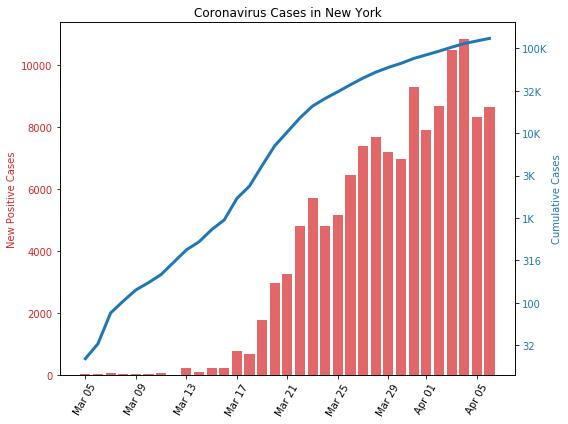

In [23]:
plot_totdaily(ny, 'New York', log=True)

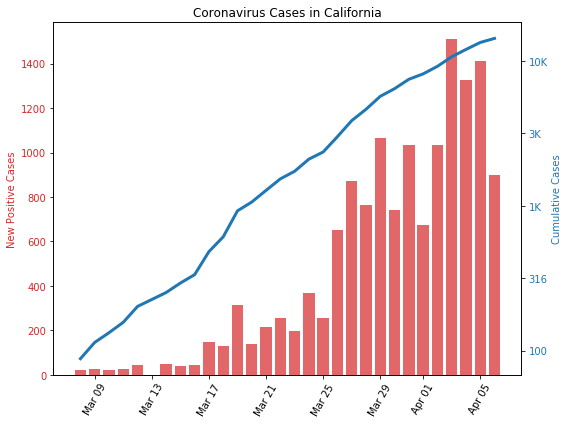

In [21]:
plot_totdaily(ca, 'California', log=True)

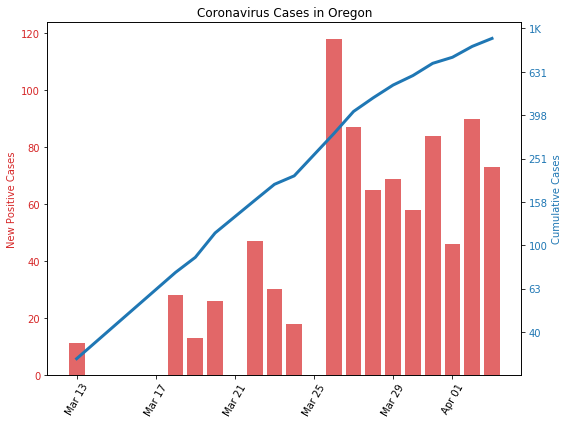

In [15]:
plot_totdaily(ore, 'Oregon')

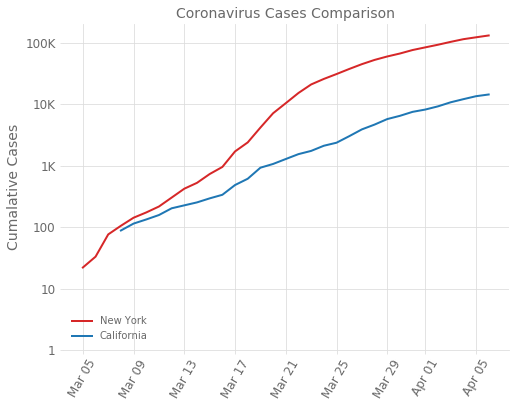

In [22]:
plot_logcomp(ny,ca, 'New York', 'California', True)